adding import lib

In [131]:
import cv2
import numpy as np
import os
import glob
import mahotas as mt
import matplotlib.pyplot as plt
#from sklearn.svm import LinearSVC

define a extract haralick features function

In [132]:
def extract_haralick_features(image):
        features = mt.features.haralick(image)

        haralick_features_mean = features.mean(axis=0)
        return haralick_features_mean

define a extract Local binary patterns (LBP) function

In [133]:
def extract_LBP(image):
    feat = mt.features.lbp(image=image, points=(2*8), radius=2, ignore_zeros="True")
    feat = np.reshape(cv2.calcHist([np.float32(feat)], [0], None, [256], [0, 256]),(256))
    return feat

Divide the picture as grids (5x4) and calculate features

In [134]:
def features_of_grid(image):
    height = image.shape[0]
    width = image.shape[1]    

    x_step = int(width / 5)
    y_step = int(height / 4)

    x = 0
    y= 0
    
    all_features = []

    for i in range(5):
        if i < 4: 
            w = x_step 
        else:
            w = width - x
        for j in range(4):
            if j < 3: 
                h = y_step 
            else:
                h = height - y
            
            crop_img = image[y:y+h, x:x+w] 
            
            y += h
            if i == 0 and j == 0:
                all_features = extract_haralick_features(crop_img)
            elif i == 0 and j == 1:
                hfc = extract_haralick_features(crop_img)
                all_features = np.stack((all_features, hfc), axis=-1)
            else:
                hfc = []
                hfc.append(extract_haralick_features(crop_img))
                hfc = np.asarray(hfc)
                all_features = np.concatenate((all_features, hfc.T), axis=1)
        x += w
        y= 0
            
    return all_features
    

get haralick features of a probe (20*2*13 - Parameters)

In [135]:
def get_haralick_feature_of_a_probe(image1_path, image2_path):
    image = cv2.imread(image1_path)
    image2 = cv2.imread(image2_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(image2, cv2.COLOR_RGB2GRAY)
    f = np.column_stack((features_of_grid(gray), features_of_grid(gray2)))
    return f


In [136]:
#Dehnrate / Gleitrate
#0,002
fs40 = get_haralick_feature_of_a_probe("../Klebeverbindungen_Daten/2D-MakroImages/ProbeR2_1.png", 
                                        "../Klebeverbindungen_Daten/2D-MakroImages/ProbeR2_2.png")

#2
fs = get_haralick_feature_of_a_probe("../Klebeverbindungen_Daten/2D-MakroImages/ProbeR3_1.png", 
                                        "../Klebeverbindungen_Daten/2D-MakroImages/ProbeR3_2.png")
#2000
fs80 = get_haralick_feature_of_a_probe("../Klebeverbindungen_Daten/2D-MakroImages/ProbeR6_1.png", 
                                        "../Klebeverbindungen_Daten/2D-MakroImages/ProbeR6_2.png")
#runde
#fr = get_haralick_feature_of_a_probe("../Klebeverbindungen_Daten/2D-MakroImages/ProbeR1_1.png", 
#                                       "../Klebeverbindungen_Daten/2D-MakroImages/ProbeR1_2.png" )

visualize calculated features

<Figure size 432x288 with 0 Axes>

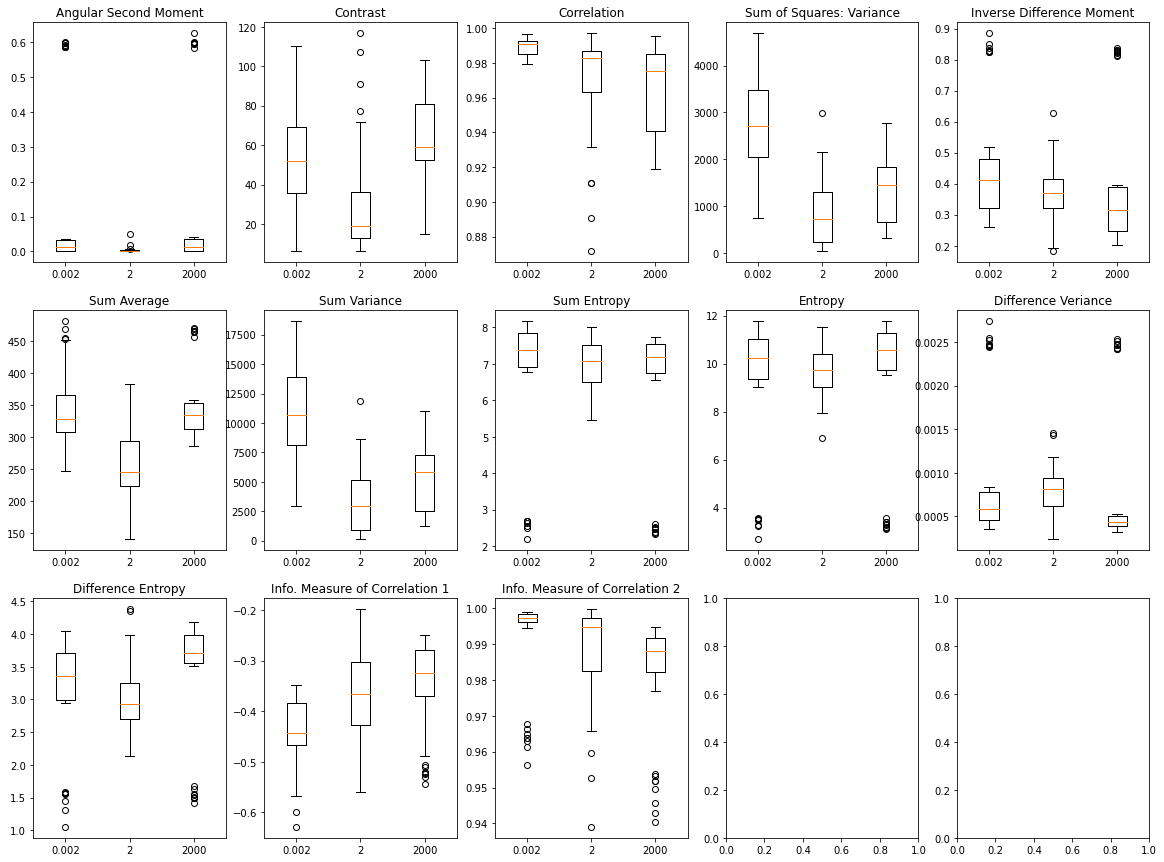

In [137]:
fig = plt.figure()

fig, axs = plt.subplots(3, 5, figsize=(20,15))
langs = ["Angular Second Moment", "Contrast", "Correlation", "Sum of Squares: Variance", "Inverse Difference Moment", "Sum Average", 
        "Sum Variance", "Sum Entropy", "Entropy", "Difference Veriance", "Difference Entropy", "Info. Measure of Correlation 1", "Info. Measure of Correlation 2"]
y_axis = np.arange(40)
for i in range(13):
        x = int(i/5)
        y = int(i % 5)
        axs[x,y].boxplot([fs40[i], fs[i], fs80[i]])
        
        axs[x,y].set_title(langs[i])
        axs[x,y].set_xticklabels([ "0.002","2", "2000"])


mean values of haralick features 

<Figure size 432x288 with 0 Axes>

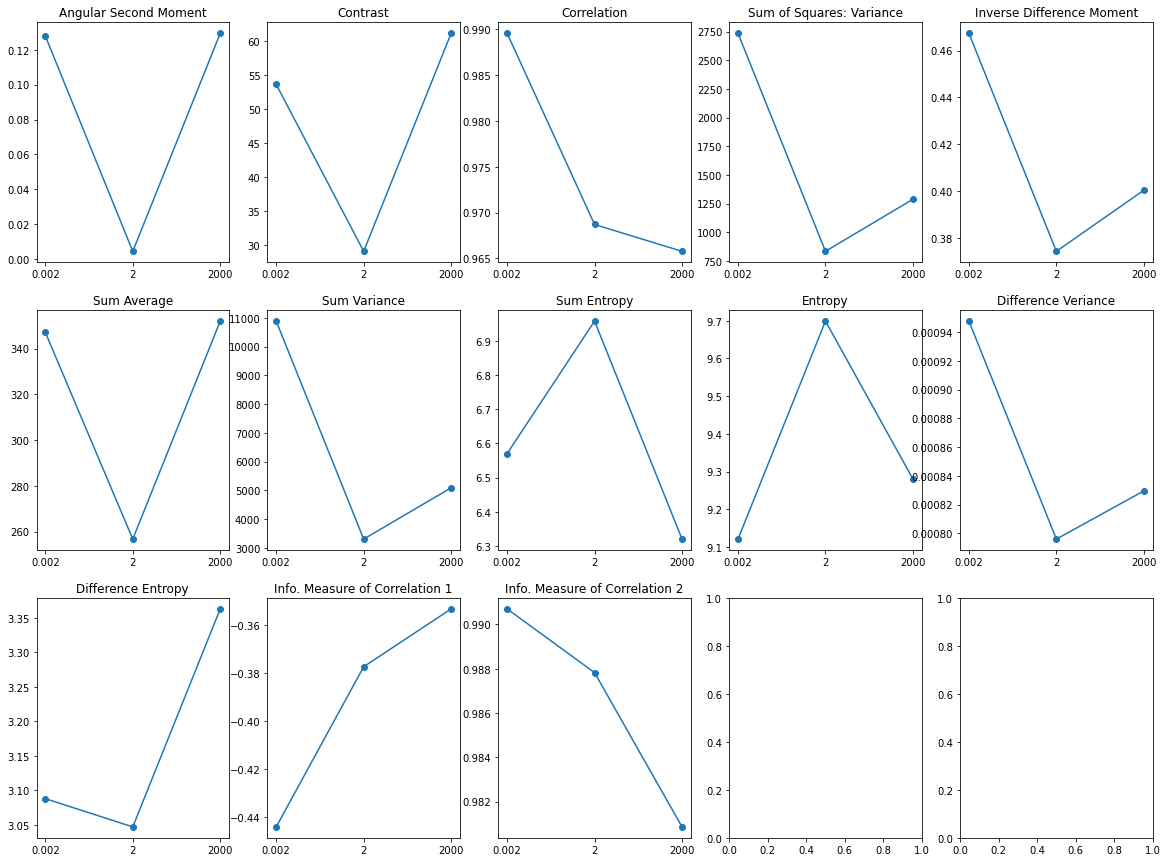

In [138]:
fig = plt.figure()

fig, axs = plt.subplots(3, 5, figsize=(20,15))
langs = ["Angular Second Moment", "Contrast", "Correlation", "Sum of Squares: Variance", "Inverse Difference Moment", "Sum Average", 
    "Sum Variance", "Sum Entropy", "Entropy", "Difference Veriance", "Difference Entropy", "Info. Measure of Correlation 1", "Info. Measure of Correlation 2"]
y_axis = np.arange(40)
for i in range(13):
    x = int(i/5)
    y = int(i % 5)
    axs[x,y].plot([np.mean(fs40[i]), np.mean(fs[i]), np.mean(fs80[i])], 'o-')
    
    axs[x,y].set_title(langs[i])
    axs[x,y].set_xticks(np.arange(3))
    axs[x,y].set_xticklabels([ "0.002","2", "2000"])


visualize of all features with PCA (principal component analysis)

In [139]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


- grid data

In [140]:
a = np.full(40, "stufe")
dfs = pd.DataFrame(data=fs.T, columns=["Angular Second Moment", "Contrast", "Correlation", "Sum of Squares: Variance", "Inverse Difference Moment", "Sum Average", 
    "Sum Variance", "Sum Entropy", "Entropy", "Difference Veriance", "Difference Entropy", "Info. Measure of Correlation 1", "Info. Measure of Correlation 2"]
)
dfs["target"] = a

a = np.full(40, "schräge30")
dfs30 = pd.DataFrame(data=fs30.T, columns=["Angular Second Moment", "Contrast", "Correlation", "Sum of Squares: Variance", "Inverse Difference Moment", "Sum Average", 
    "Sum Variance", "Sum Entropy", "Entropy", "Difference Veriance", "Difference Entropy", "Info. Measure of Correlation 1", "Info. Measure of Correlation 2"]
)
dfs30["target"] = a

a = np.full(40, "schräge60")
dfs60 = pd.DataFrame(data=fs60.T, columns=["Angular Second Moment", "Contrast", "Correlation", "Sum of Squares: Variance", "Inverse Difference Moment", "Sum Average", 
    "Sum Variance", "Sum Entropy", "Entropy", "Difference Veriance", "Difference Entropy", "Info. Measure of Correlation 1", "Info. Measure of Correlation 2"]
)
dfs60["target"] = a

a = np.full(40, "runde")
dfr = pd.DataFrame(data=fr.T, columns=["Angular Second Moment", "Contrast", "Correlation", "Sum of Squares: Variance", "Inverse Difference Moment", "Sum Average", 
    "Sum Variance", "Sum Entropy", "Entropy", "Difference Veriance", "Difference Entropy", "Info. Measure of Correlation 1", "Info. Measure of Correlation 2"]
)
dfr["target"] = a

frames = [dfs, dfs30, dfs60, dfr]
df = pd.concat(frames)
df


NameError: name 'fs30' is not defined

     principal component 1  principal component 2 target
0                -2.739845               2.685227  stufe
1                -2.710858               3.416485  stufe
2                -2.459980               0.730798  stufe
3                -2.093086              -0.736129  stufe
4                -3.049666               2.627373  stufe
..                     ...                    ...    ...
155               1.752877              -1.004322  runde
156               8.436312               2.749987  runde
157               1.477094              -0.085119  runde
158               0.517489              -1.190049  runde
159               8.366107               2.498038  runde

[160 rows x 3 columns]


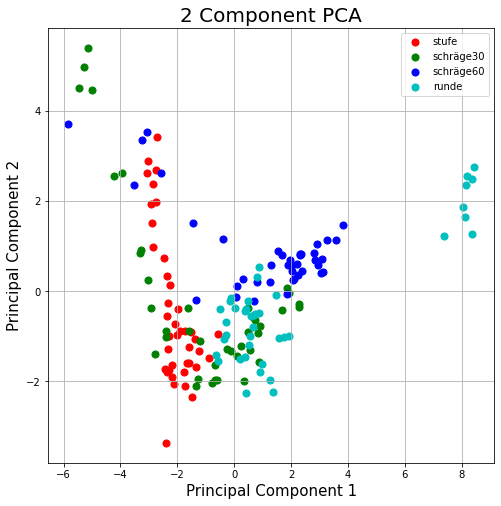

In [ ]:
features = ["Angular Second Moment", "Contrast", "Correlation", "Sum of Squares: Variance", "Inverse Difference Moment", "Sum Average", 
    "Sum Variance", "Sum Entropy", "Entropy", "Difference Veriance", "Difference Entropy", "Info. Measure of Correlation 1", "Info. Measure of Correlation 2"]
x = df.loc[:, features].values
y = df.loc[:,['target']].values
x = StandardScaler().fit_transform(x)
pd.DataFrame(data = x, columns = features).head()
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])


finalDf = principalDf
finalDf['target'] = y
print(finalDf)

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 Component PCA', fontsize = 20)


targets = ['stufe', 'schräge30', 'schräge60', 'runde']
colors = ['r', 'g', 'b', 'c']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['target'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

- data with mean values

In [ ]:
mean_data = []
mean_data.append(np.mean(fs, axis = 1))
mean_data.append(np.mean(fs30, axis = 1))
mean_data.append(np.mean(fs60, axis = 1))
mean_data.append(np.mean(fr, axis = 1))

df = pd.DataFrame(data=mean_data, index = ["0", "30", "60", "90"], columns=["Angular Second Moment", "Contrast", "Correlation", "Sum of Squares: Variance", "Inverse Difference Moment", "Sum Average", 
    "Sum Variance", "Sum Entropy", "Entropy", "Difference Veriance", "Difference Entropy", "Info. Measure of Correlation 1", "Info. Measure of Correlation 2"]
)
df

,Angular Second Moment,Contrast,Correlation,Sum of Squares: Variance,Inverse Difference Moment,Sum Average,Sum Variance,Sum Entropy,Entropy,Difference Veriance,Difference Entropy,Info. Measure of Correlation 1,Info. Measure of Correlation 2
0,0.000428,127.161515,0.951405,1676.991063,0.201548,240.743934,6580.802739,8.106796,12.237997,0.000290,4.287232,-0.281005,0.982032
30,0.000801,138.009938,0.949753,1412.613464,0.269147,310.452178,5512.443919,7.981898,11.681057,0.000431,3.928074,-0.335082,0.982238
60,0.004347,89.244151,0.938316,489.990668,0.406630,374.140141,1870.718522,6.817443,9.541944,0.000765,3.143974,-0.372829,0.989131
90,0.129062,42.002858,0.982506,1391.308110,0.461913,369.805042,5523.229582,6.403273,8.976547,0.000951,3.022991,-0.425465,0.988442


             P1         P2
0  -1764.767633 -47.248047
30  -663.052432 -25.239371
60  3094.431889 -13.771677
90  -666.611824  86.259095


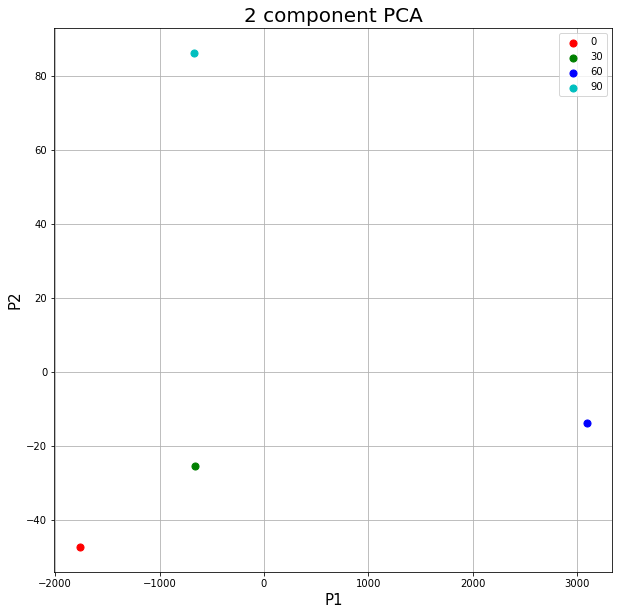

In [ ]:
pca = PCA(n_components=2)
principalComponent = pca.fit_transform(df.values)
principalDf = pd.DataFrame(data = principalComponent, index = ["0", "30", "60", "90"], columns=["P1", "P2"])

print(principalDf)

fig  = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('P1', fontsize = 15)
ax.set_ylabel('P2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)

targets =  ["0", "30", "60", "90"]
colors = ['r', 'g', 'b', 'c']
for target, color in zip(targets, colors):
    ax.scatter(principalDf.loc[target, "P1"], principalDf.loc[target, "P2"], c = color, s = 50)

ax.legend(targets)
ax.grid()